In [1]:
!git clone https://github.com/TaikiiNomura/ScheduleFree.git

Cloning into 'ScheduleFree'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 111 (delta 64), reused 87 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (111/111), 18.49 KiB | 9.24 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
%ls ScheduleFree/optimizer

adamw_schedulefree.py  adina.py  adina_schedulefree.py  sgd_schedulefree.py


In [3]:
import sys
import os

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
from ScheduleFree.optimizer import sgd_schedulefree, adamw_schedulefree, adina, adina_schedulefree
from ScheduleFree.trainer import run
from ScheduleFree.utils import plot

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
batch_size = 64
test_batch_size = 1000
lr = 0.0005
num_epochs = 10
log_interval = 200

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.Flatten(start_dim = 1)(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
all_train_losses = {}
all_train_accuracies = {}
all_test_losses = {}
all_test_accuracies = {}

# 新しい手法を追加するときはここも追加
optimizer_info = {
    'sgd': {'name':'sgd','type':'null', 'color': 'r', 'label': 'sgd'},
    'adamw': {'name':'adamw','type':'null', 'color': 'g', 'label': 'adamw'},
    'adina': {'name':'adina','type':'null', 'color': 'b', 'label': 'adina'},
    'sgd_schedulefree': {'name':'sgd_schedulefree','type':'schedulefree', 'color': 'm', 'label': 'sgd_schedulefree'},
    'adamw_schedulefree': {'name':'adamw_schedulefree','type':'schedulefree', 'color': 'y', 'label': 'adamw_schedulefree'},
    'adina_schedulefree': {'name':'adina_schedulefree','type':'schedulefree', 'color': 'c', 'label': 'adina_schedulefree'}
}


for name in optimizer_info.keys():
    all_train_losses[name] = []
    all_train_accuracies[name] = []
    all_test_losses[name] = []
    all_test_accuracies[name] = []

seed = 999  # 任意の整数
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
# 最初に一度だけ初期モデルを作成し、状態を保存
initial_model = Net()
initial_state_dict = initial_model.state_dict()

for name, info in optimizer_info.items():

    print(f'--- {info["name"]} ---')

    model = Net().to(device)
    model.load_state_dict(initial_state_dict)

    if name == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr = lr,
            momentum = 0
        )
    elif name == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr = lr,
            weight_decay = 1e-2
        )
    elif name == 'adina':
        optimizer = adina.Adina(
            model.parameters(),
            lr = lr,
            a = 0.1,
            b = 0.9
        )
    elif name == 'sgd_schedulefree':
        optimizer = sgd_schedulefree.SGDScheduleFree(
            model.parameters(),
            lr = lr,
            beta = 0.0
        )
    elif name == 'adamw_schedulefree':
        optimizer = adamw_schedulefree.AdamWScheduleFree(
            model.parameters(),
            lr = lr,
            weight_decay = 1e-2,
        )
    elif name == 'adina_schedulefree':
        optimizer = adina_schedulefree.AdinaScheduleFree(
            model.parameters(),
            lr = lr,
            a = 0.1,
            b = 0.9,
            num_schedulefree=0.9
        )
    else:
        print(f"Unknown optimizer: {name}")
        continue

    train_losses_list, train_accuracies_list, test_losses_list, test_accuracies_list = run.run_schedulefree(
        model,
        optimizer,
        num_epochs,          # Pass num_epochs
        log_interval,      # Pass log_interval
        device,              # Pass device
        train_loader,      # Pass train_loader
        test_loader,        # Pass test_loader
        info['type'],        # Pass optimizer_type
        info['name']         # Pass optimizer_name
    )

    all_train_losses[name] = train_losses_list
    all_train_accuracies[name] = train_accuracies_list
    all_test_losses[name] = test_losses_list
    all_test_accuracies[name] = test_accuracies_list

--- sgd ---
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300343
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.279974
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.287620
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.290854
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.291880

Test set: Average loss: 2.2896
Accuracy: 1563/10000
(15.63%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.285311
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.268193
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.272353
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.275132
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.275749

Test set: Average loss: 2.2730
Accuracy: 2281/10000
(22.81%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.268711
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.254590
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.254733
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.256278
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.256199

Test set: Average loss: 2.2530
Accuracy: 2768/10000
(27.68%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.248235
Train Epoch: 4 [128

lr = 0.0005
batch_size = 64


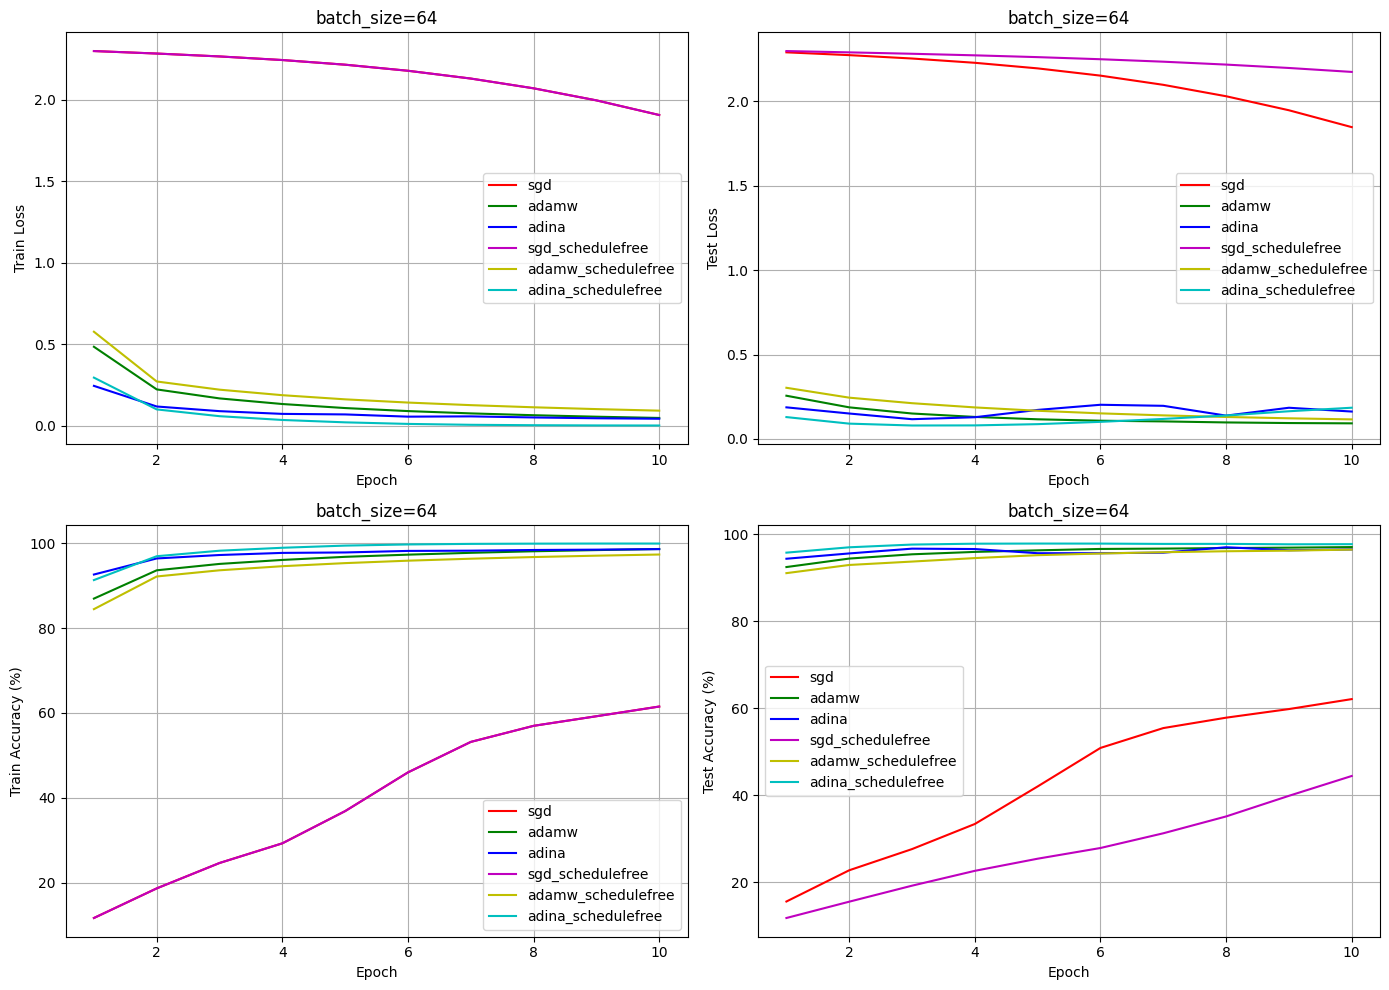

In [10]:
plot.plot_loss_accuracy(lr, num_epochs, batch_size, all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies, optimizer_info)